In [1]:
%matplotlib inline
import numpy as np
import lib.io.stan
import lib.syn_data
import matplotlib.pyplot as plt
import os

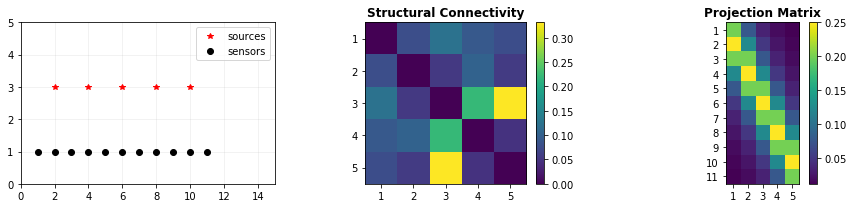

In [2]:
results_dir = 'results/exp7'
os.makedirs(f'{results_dir}/figures',exist_ok=True)
os.makedirs(f'{results_dir}/logs',exist_ok=True)
np.random.seed(0)

x = np.r_[2:12:2]
y = np.repeat(np.array([3.0]),np.size(x))
src_locs = np.array(list(zip(x,y)))
nNodes = np.size(src_locs,0)
x = np.r_[1:12:1]
y = np.repeat(np.array([1.0]),np.size(x))
snsr_locs = np.array(list(zip(x,y)))
nSnsrs = np.size(snsr_locs,0)


plt.figure(figsize=[12,3])
plt.subplot(131)
plt.plot(src_locs[:,0],src_locs[:,1],'r*',label='sources')
plt.plot(snsr_locs[:,0],snsr_locs[:,1],'ko',label='sensors')
plt.xlim([0,15])
plt.ylim([0,5])
plt.grid(1,alpha=0.2)
plt.legend(loc='upper right')

ax = plt.subplot(132)
SC = lib.syn_data.gen_con(nNodes)

im = plt.imshow(SC)
plt.xticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.yticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.colorbar(fraction=0.046, pad=0.04)
plt.gca().set_title("Structural Connectivity",fontweight="bold")

proj_mat = lib.syn_data.comp_proj_mat(src_locs,snsr_locs)

plt.subplot(133)
plt.imshow(proj_mat)
plt.xticks(np.arange(0,nNodes),map(str,np.arange(1,nNodes+1)))
plt.yticks(np.arange(0,nSnsrs),map(str,np.arange(1,nSnsrs+1)))
plt.colorbar(fraction=0.046,pad=0.04)
plt.gca().set_title("Projection Matrix",fontweight="bold")

plt.tight_layout()
plt.savefig(f'{results_dir}/figures/network.png')


np.savez(f'{results_dir}/network.npz', src_locs=src_locs, snsr_locs = snsr_locs, \
        SC=SC, proj_mat=proj_mat)

In [ ]:
nn = nNodes
ns = nSnsrs
I1 = 3.1
tau0 = 30.0
k = 2.0
Ic = np.zeros(nn)

x0 = -2.5*np.ones(nn)
x0[2] = -1.8
x0[4] = -2.2
time_scale = 1.0
time_step = 0.1
sigma = 0.01
nt = 50*int(1/time_step)
epsilon = 0.1
amplitude = 1.0
offset = 0.0

x_init = -0.5*np.ones(nn)
z_init = 1.5*np.ones(nn)
z_eta = np.random.normal(0.0, 1.0, [nt-1, nn])

data = {'nn':nn, 'ns':ns, 'nt':nt, 'I1':I1, 'tau0':tau0, 'Ic':Ic, 'SC':SC, 
        'gain': proj_mat, 'sigma':sigma, 'k':k, 'epsilon': epsilon, 'amplitude': amplitude,
        'offset': offset, 'x0':x0, 'time_scale':time_scale, 'time_step':time_step,
        'x_init':x_init, 'z_init':z_init, 'z_eta': z_eta}

lib.io.stan.rdump(f'{results_dir}/sim_data.R',data)

stan_fname = './vep-snsrfit-sim'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)
sim_cmd = f'{stan_fname} sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
file={results_dir}/sim_data.R output file={results_dir}/sim_out.csv'
lib.io.stan.create_process(sim_cmd.split(),block=True)

In [ ]:
# t = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')

x = t['x'][0]
z = t['z'][0]
seeglp = t['seeg_log_power'][0]

plt.figure(figsize=[15,4])
plt.subplot(121)
for i in range(nn):
    plt.plot(x.T[:,i]/4.0 + i,label=f'node{i+1}',color='black')
plt.yticks(np.mean(x.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('x',fontsize=15.0)
plt.suptitle('Source Signals')
plt.subplot(122)
for i in range(nn):
    plt.plot(z.T[:,i]/4.0 + i,label=f'node{i}',color='black')
plt.yticks(np.mean(z.T/4.0 + np.arange(nn),axis=0), map(lambda x: f'node {x}',np.arange(1,nn+1)))
plt.xlabel('time')
plt.gca().set_title('z',fontsize=15.0)
plt.savefig(f'{results_dir}/figures/src_signals.png')

plt.figure(figsize=[15,4])
plt.subplot(1,2,1)
plt.plot(seeglp.T + np.r_[0:2*ns:2],'k')
plt.yticks(np.mean(seeglp.T + np.r_[0:2*ns:2],axis=0), map(lambda x: f'snsr {x}',np.arange(1,ns+1)))
plt.xlabel('time(ms)')
plt.title('seeg log power',fontsize=15.0)
plt.subplot(1,2,2)
plt.plot(np.r_[1:nn+1],x0,'ko')
plt.xlabel('Node#')
plt.xticks(np.arange(1,nn+1),map(str,np.arange(1,nn+1)))
plt.ylabel('$x_0$',fontsize=12.0)
plt.grid(alpha=0.3)
plt.savefig(f'{results_dir}/figures/seeg_log_power.png')

In [ ]:
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(x[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('x',fontsize=15.0)
    plt.ylim([-3.0,1.0])
    plt.gca().set_title(f'node {i+1}')
plt.savefig(f'{results_dir}/figures/src_signals_2.png')    
    
plt.tight_layout()
plt.figure(figsize=[15,3])
for i in range(nn):
    plt.subplot(1,5,i+1)
    plt.plot(z[i,:],'k')
    plt.xlabel('time')
    plt.ylabel('z',fontsize=15.0)
    plt.ylim([2.0,5.0])
    plt.gca().set_title(f'node {i+1}')
plt.tight_layout()
plt.savefig(f'{results_dir}/figures/src_signals_3.png')

In [ ]:
data = lib.io.stan.rload(f'{results_dir}/sim_data.R')

infer_params = ['x0']
for param in infer_params:
    del(data[param])

sel_snsrs = np.r_[1:12] # sensors used for fitting
data['ns'] = np.size(sel_snsrs)
data['gain'] = data['gain'][sel_snsrs-1,:]
data['seeg_log_power'] = seeglp[sel_snsrs-1,:].T
results_subdir = results_dir+'/snsrs-'+'-'.join([str(el) for el in sel_snsrs])
os.makedirs(results_subdir,exist_ok=True)
lib.io.stan.rdump(f'{results_subdir}/fit_data.R',data)

stan_fname = './vep-snsrfit'
lib.io.stan.create_process(['bash','/home/anirudhnihalani/scripts/stancompile.sh', stan_fname],block=True)

nchains = 8
with open('vep-snsrfit.sh','r') as fd:
    slurm_script = fd.read().format(results_subdir,nchains)
with open('tmp/vep-snsrfit.sh','w') as fd:
    fd.write(slurm_script)
lib.io.stan.create_process(['sbatch','tmp/vep-snsrfit.sh'],block=False)


In [ ]:
chains = [1,2,3,4,5,6,7,8]
plt.figure(figsize=[14,8])
j = 0
for i in chains:
    j = j + 1
    t = lib.io.stan.parse_csv(f'{results_subdir}/samples_chain{i}.csv')    
    plt.subplot(3,3,j)
    plt.violinplot(t['x0'][500:,:])
#     plt.ylim([-3.5,-0.5])
    plt.xlabel('Node#',fontsize=13)
    plt.ylabel('$x_0$',fontsize=13)
    plt.gca().set_title(f'Chain {i}')

plt.subplot(3,3,9)
t = lib.io.stan.rload(f'{results_dir}/sim_data.R')
x0 = t['x0']
plt.plot(np.arange(1,np.size(x0)+1),x0,'ko')
# plt.ylim([-3.5,-0.5])
plt.grid(alpha=0.3)
plt.xlabel('Node#',fontsize=13)
plt.ylabel('$x_0$',fontsize=13)
plt.gca().set_title('True $x_0$ values')
plt.tight_layout()
os.makedirs(f'{results_subdir}/figures',exist_ok=True)
plt.savefig(f'{results_subdir}/figures/posterior_violins.png')

Compute the predictive distrubtion and $\hat r$

In [ ]:
chains = [1,2,3,4,5,6,7,8]
sim_data = lib.io.stan.rload(f'{results_dir}/sim_data.R')
fit_data = lib.io.stan.rload(f'{results_subdir}/fit_data.R')
for i in chains:
    t = lib.io.stan.parse_csv(f'{results_subdir}/samples_chain{i}.csv')
    x0_samples = t['x0'][500:,:]
    slp_pred_dist = np.zeros([np.size(x0_samples, 0),
                           fit_data['ns'],fit_data['nt']]) # Predictive distribution of seeg_log_power for a chain
    for j,x0 in enumerate(x0_samples):
        data = sim_data
        data['x0'] = x0
        data['gain'] = fit_data['gain']
        data['ns'] = fit_data['ns']
        lib.io.stan.rdump('tmp/sim_data.R',data)
        sim_cmd = f'./vep-snsrfit-sim sample algorithm=fixed_param num_samples=1 num_warmup=0 data \
        file=tmp/sim_data.R output file=tmp/sim_out.csv'
        lib.io.stan.create_process(sim_cmd.split(),block=True,stdout=open('/dev/null','ab'))
        t = lib.io.stan.parse_csv('tmp/sim_out.csv')
        slp_pred_dist[j,:,:] = t['seeg_log_power'][0]
    np.save(f'{results_subdir}/pred_dist_chain{i}.npy',slp_pred_dist)

stan_dir = '/home/anirudhnihalani/soft/cmdstan-2.17.0/bin'
rhats = np.zeros([len(chains),nn])
for i in chains:
    summary_fname = f'{results_subdir}/summary_chain{i}.csv'
    if(os.path.isfile(summary_fname)):
        os.remove(summary_fname)
    cmd = f'{stan_dir}/stansummary \
            --csv_file={summary_fname} \
            {results_subdir}/samples_chain{i}.csv'
    stdout = open('/dev/null','ab')
    lib.io.stan.create_process(cmd.split(),block=True,stdout=stdout)
    t = lib.io.stan.parse_summary_csv(f'{results_subdir}/summary_chain{i}.csv')
    rhats[i-1,:] = t[1]['x0'][:,-1]
np.save(f'{results_subdir}/rhats.npy',rhats)

In [ ]:
t = lib.io.stan.parse_csv(f'{results_dir}/sim_out.csv')
slp_true = t['seeg_log_power'][0,sel_snsrs,:].T
t = lib.io.stan.rload(f'{results_dir}/sim_data.R')
x0_true = t['x0']
chains = [1,2,3,4,5,6,7,8]
plt.figure(figsize=[12,20])
plt.subplot(len(chains)+1, 2, 1)
plt.plot(slp_true)
plt.xlabel('time')
plt.ylabel('seeg log power',fontsize=13.0)
plt.gca().set_title('Ground Truth')
plt.subplot(len(chains)+1, 2, 2)
plt.plot(np.r_[1:x0_true.size+1],x0_true,'ko')
# plt.ylim([-3.5,-0.5])
plt.grid(alpha=0.3)
plt.xticks(np.r_[1:nn+1], np.r_[1:nn+1])
plt.xlabel('Node#',fontsize=13)
plt.ylabel('$x_0$',fontsize=13)
plt.gca().set_title('True $x_0$ values')

rhats = np.load(f'{results_subdir}/rhats.npy')
for i in chains:
    slp_pred_dist = np.load(f'{results_subdir}/pred_dist_chain{i}.npy')
    slp_pred_mean = np.mean(slp_pred_dist,axis=0).T
    slp_pred_sd = np.std(slp_pred_dist,axis=0).T
    plt.subplot(len(chains)+1, 2, 2*i + 1)
    plt.plot(slp_pred_mean)
    ub = slp_pred_mean + slp_pred_sd
    lb = slp_pred_mean - slp_pred_sd
    for j in range(slp_pred_mean.shape[1]):
        plt.fill_between(range(slp_pred_mean.shape[0]), ub[:,j], lb[:,j], alpha=0.3)
    plt.xlabel('time', fontsize=13.0)
    plt.ylabel('seeg log power', fontsize=13.0)

    t = lib.io.stan.parse_csv(f'{results_subdir}/samples_chain{i}.csv')    
    plt.subplot(len(chains)+1, 2, 2*i + 2)
    plt.violinplot(t['x0'][200:,:])
    plt.xticks(np.r_[1:nn+1], ['{:.1f}'.format(el) for el in rhats[i-1,:]])
#     plt.ylim([-3.5,-0.5])
    plt.ylabel('$x_0$',fontsize=13)
    plt.gca().set_title(f'chain {i}')
plt.tight_layout()
plt.savefig(f'{results_subdir}/figures/pred_dist.png')